In [11]:
def make_features_dic(fname):
    with open(fname) as file:
        return {line.rstrip('\n'): i for i, line in enumerate(file)}

In [12]:
def make_queue(fname, features_dic):
    with open(fname) as file:
        lines = file.readlines()
        queue_x = np.zeros([len(lines), len(features_dic)])
        queue_y = np.zeros([len(lines), 4]) # One-hot表現: [b, t, e, m]
        
        for i, line in enumerate(lines):
            import re
            from nltk.corpus import stopwords
            import snowballstemmer
            
            line = line.rstrip('\n')
            category = line.strip('\t')[0]
            title = line.split('\t')[1]
            
            # queue_xの処理
            # 文字種の統一
            title = title.lower()
            
            # 数字の置き換え -> 除去
            title = re.sub(r'[0-9]+', '', title)
            
            # '-'を' 'に変換
            title = title.replace('-', ' ')
            
            words = title.split()
            
            # ストップワードの除去
            stop_words = stopwords.words('english')
            words2 = [word for word in words if word not in stop_words]
            words = words2
            
            # ステミング処理
            stemmer = snowballstemmer.stemmer('english')
            words2 = [stemmer.stemWord(word) for word in words]
            words = words2
            
            # 記号の除去
            words2 = [word for word in words if word.islower()]
            words = words2
            
            for word in words:
                if word in features_dic.keys():
                    queue_x[i, features_dic[word]] = 1
                    
            # queue_yの処理
            if category == 'b':
                queue_y[i, 0] = 1
            elif category == 't':
                queue_y[i, 1] = 1
            elif category == 'e':
                queue_y[i, 2] = 1
            elif category == 'm':
                queue_y[i, 3] = 1
                
    return queue_x, queue_y

In [13]:
def softmax(queue): # ソフトマックス関数
    return np.exp(queue) / np.sum(np.exp(queue), axis = 1)[:, np.newaxis]

In [14]:
def calculate_gradient(queue_x, queue_y, queue_w, vector_b, rp):
    phi = softmax(np.dot(queue_x, queue_w) + vector_b)
    
    vector_l2_norm = np.zeros(len(queue_w))
    for i in range(len(queue_w)):
        vector_l2_norm[i] = np.sqrt(np.sum(np.square(queue_w[i])))
    l2 = (rp / 2) * np.sum(vector_l2_norm) # L2正則化項
    
    closs_entropy = -np.sum(queue_y * np.log(phi)) +l2 # 交差エントロピー
    
    l2_dw = np.zeros(queue_w.shape) # L2正則化項のwについての偏微分
    for i in range(len(queue_w)):
        for j in range(4):
            l2_dw = (rp / 2) * (queue_w[i][j] / vector_l2_norm[i])
    
    dw = -np.dot(queue_x.T, queue_y - phi) + l2_dw
    db = -np.dot(np.ones([1, queue_y.shape[0]]), queue_y - phi)
    
    return dw, db

In [15]:
def train(queue_x, queue_y, queue_w, vector_b, lr, rp):
    dw, db = calculate_gradient(queue_x, queue_y, queue_w, vector_b, rp)
    queue_w -= lr * dw
    vector_b -= lr * db
    
    return queue_w, vector_b

In [16]:
def valid(queue_x, queue_y, queue_w, vector_b):
    pred_queue_y = np.zeros(queue_y.shape)
    phi = softmax(np.dot(queue_x, queue_w) + vector_b)
    class_labels = np.argmax(phi, axis = 1)
    correct_count = 0
    
    for i in range(len(queue_y)):
        pred_queue_y[i, class_labels[i]] = 1
    for i in range(len(queue_y)):
        if np.all(queue_y[i, :] == pred_queue_y[i, :]):
            correct_count += 1
            
    return correct_count / len(queue_y)

In [17]:
def make_model(exponent):
    import numpy as np
    
    features_dic = make_features_dic('train.feature.txt')
    train_queue_x, train_queue_y = make_queue('train.txt', features_dic)
    valid_queue_x, valid_queue_y = make_queue('valid.txt', features_dic)
    lr = pow(10, -3) # 学習率: 検証の結果、最も精度が高かった数値
    rp = pow(10, exponent) # 正則化パラメータ
    queue_w = np.ones([len(features_dic), 4])
    vector_b = np.ones([1, 4])
    accuracy, best_accuracy, pre_best_accuracy = 0, 0, 0
    count = 1
    
    while True:
        pre_queue_w = queue_w
        pre_vector_b = vector_b
        
        queue_w, vector_b = train(train_queue_x, train_queue_y, pre_queue_w, pre_vector_b, lr, rp)
        accuracy = valid(valid_queue_x, valid_queue_y, queue_w, vector_b)
        if accuracy > best_accuracy:
            best_queue_w = queue_w
            best_vector_b = vector_b
            best_accuracy = accuracy
            best_count = count
        if count % 1000 == 0:
            if best_accuracy == pre_best_accuracy:
                break
            pre_best_accuracy = best_accuracy
        count += 1
    print('[{0}] {1}'.format(best_count, best_accuracy))
            
    return best_queue_w, best_vector_b

In [18]:
def get_accuracy(fname, queue_w, vector_b):
    features_dic = make_features_dic('train.feature.txt')
    queue_x, queue_y = make_queue(fname, features_dic)
    accuracy = valid(queue_x, queue_y, queue_w, vector_b)
    
    return accuracy

In [19]:
def get_accuracys(exponent, fname, fname2, fname3):
    queue_w, vector_b = make_model(exponent)
    accuracy = get_accuracy(fname, queue_w, vector_b)
    accuracy2 = get_accuracy(fname2, queue_w, vector_b)
    accuracy3 = get_accuracy(fname3, queue_w, vector_b)
    
    vector_l2_norm = np.zeros(len(queue_w))
    for i in range(len(queue_w)):
        vector_l2_norm[i] = np.sqrt(np.sum(np.square(queue_w[i])))
    print('パラメータの大きさ: {0}'.format(np.sum(vector_l2_norm)))
    
    return accuracy, accuracy2, accuracy3

In [22]:
import numpy as np

fname = 'train.txt'
fname2 = 'valid.txt'
fname3 = 'test.txt'
rps = []
train_accuracys = []
valid_accuracys = []
test_accuracys = []

for i in range(0, 5):
    print('正則化パラメータ: 10^{0}'.format(i))
    accuracy, accuracy2, accuracy3 = get_accuracys(i, fname, fname2, fname3)
    rps.append(pow(10, i))
    train_accuracys.append(accuracy)
    valid_accuracys.append(accuracy2)
    test_accuracys.append(accuracy3)
    print('学習データ: {0}\t検証データ: {1}\t評価データ: {2}\n'.format(accuracy, accuracy2, accuracy3))

正則化パラメータ: 10^0
[1166] 0.9167916041979011
パラメータの大きさ: 7317.690332357281
学習データ: 0.9964426137427448	検証データ: 0.9145427286356822	評価データ: 0.9092953523238381

正則化パラメータ: 10^1
[1166] 0.9167916041979011
パラメータの大きさ: 5443.30107012985
学習データ: 0.9964426137427448	検証データ: 0.9145427286356822	評価データ: 0.9092953523238381

正則化パラメータ: 10^2
[1166] 0.9167916041979011
パラメータの大きさ: 5443.699306763107
学習データ: 0.9964426137427448	検証データ: 0.9145427286356822	評価データ: 0.9092953523238381

正則化パラメータ: 10^3
[1166] 0.9167916041979011
パラメータの大きさ: 5443.737527636071
学習データ: 0.9964426137427448	検証データ: 0.9145427286356822	評価データ: 0.9092953523238381

正則化パラメータ: 10^4
[1166] 0.9167916041979011
パラメータの大きさ: 24037.96449278934
学習データ: 0.9964426137427448	検証データ: 0.9145427286356822	評価データ: 0.9092953523238381



/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22793 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 22793 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26908 missing from curre

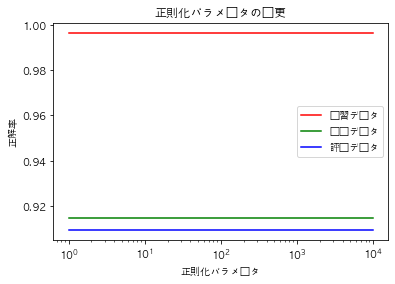

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'
    
plt.plot(rps, train_accuracys, color='r', label='学習データ')
plt.plot(rps, valid_accuracys, color='g', label='検証データ')
plt.plot(rps, test_accuracys, color='b', label='評価データ')
plt.xscale('log')
plt.title('正則化パラメータの変更')
plt.xlabel('正則化パラメータ')
plt.ylabel('正解率')
plt.legend()
plt.show()